# POPULATION SYNTHESIS
## VALIDATION OF METRICS


In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from synthpop.recipes.starter2 import Starter
from synthpop.census_helpers import Census
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd

### Downloading Your Synthesized Data
Download the households and persons csv files created during your region population synthesis which were saved in the data folder in this directory.
Files to download:
* hh_MA_NameCounty_2013.csv
* p_MA_NameCounty_2013.csv

Read the csv data and set index names:

In [3]:
state='IL'
county='DuPage'

In [17]:
hh_synth = pd.read_csv('/home/max/projects/synthpop/scripts/DuPage_County_hh_synth_parallel_2019-08-13.csv'.\
                       format(state,county),index_col='household_id', dtype={'serialno':'str',
                                                                        'state':'str',
                                                                        'county':'str',
                                                                        'tract':'str',
                                                                        'block group':'str'})
p_synth = pd.read_csv('/home/max/projects/synthpop/scripts/DuPage_County_p_synth_parallel_2019-08-13.csv'.\
                      format(state,county),index_col='person_id', dtype={'serialno':'str'})

# making a geoid column to map the discrepancy later and for the groupby
hh_synth['geoid']=hh_synth['state'].astype(str) + hh_synth['county'].astype(str) + hh_synth['tract'].astype(str) +\
                    hh_synth['block group'].astype(str)

print ('Loaded {:,} household records.'.format(len(hh_synth)))
print ('Loaded {:,} person records.'.format(len(p_synth)))

Loaded 338,375 household records.
Loaded 889,096 person records.


In [18]:
hh_synth.head()

,serialno,persons,group_quarters,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,state,county,tract,block group,children,tenure,recent_mover,geoid
household_id,,,,,,,,,,,,,,,,,,
0,2011000157103,3,1,2.0,0.0,48000.0,1,yes,60,2.0,17,043,840101,3,NaN,1,0,170438401013
1,2011000157103,3,1,2.0,0.0,48000.0,1,yes,60,2.0,17,043,840101,3,NaN,1,0,170438401013
2,2011000157103,3,1,2.0,0.0,48000.0,1,yes,60,2.0,17,043,840101,3,NaN,1,0,170438401013
3,2012001257245,6,1,2.0,0.0,46500.0,1,no,60,1.0,17,043,840101,3,3.0,1,0,170438401013
4,2009001368742,1,1,2.0,1.0,58500.0,1,no,62,NaN,17,043,840101,3,NaN,1,0,170438401013


In [19]:
p_synth.head()

,member_id,age,relate,edu,sex,hours,earning,race_id,hispanic,household_id,student,work_at_home,worker,self_employed,unemployed,nilf
person_id,,,,,,,,,,,,,,,,
0,2,64,1,22.0,2,7.0,3500.0,1,no,366,0,0,1,0,0,0
1,1,62,0,21.0,1,45.0,58500.0,1,no,366,0,0,1,1,0,0
2,1,68,0,20.0,2,37.0,34000.0,1,no,182,0,0,1,0,0,0
3,2,62,1,19.0,2,NaN,0.0,1,no,367,0,0,0,0,0,1
4,3,94,8,7.0,2,NaN,0.0,1,no,367,0,0,0,0,0,1


### Getting Marginal Distribution
Now lets get our same dataset we used to base the synthesis off of and format it for use in validating the synthesised data versus the expected data.

In order to download census data, you need a census API key. If you do not yet have a key you may request one here from the census. Afterwards, set the key as a environmental variable on your machine and call it 'CENSUS'.

In [20]:
# The os library reads the environmental variable saved on your machine
def key():
    return os.environ['CENSUS']

If you are unable set your key manually you may run this below to set it in your environmental variables, replace [API KEY] with your key.

In [21]:
# os.environ['CENSUS'] = [API KEY]

Download the data and filter by the state fips code and drop block groups with zero househlds and persons

In [22]:
starter = Starter(key(), state, county+' County', acsyear= 2013)

geog = starter.c.try_fips_lookup(state,county+' County')
ind = pd.Series([geog[0]], index=["state"])

hh_target=starter.get_household_marginal_for_geography(ind)
p_target=starter.get_person_marginal_for_geography(ind)

# add state fips code
state_fips = pd.Series([geog[0]], index=["state"])[0]
hh_target = pd.concat([hh_target], keys=[state_fips], names=['state'])
p_target = pd.concat([p_target], keys=[state_fips], names=['state'])

# drop census block groups with zero household
hh_target2=hh_target[hh_target['hh_age_of_head'].sum(axis=1)>0]
p_target2=p_target[p_target['person_sex'].sum(axis=1)>0]

Let's look at the marginal tables that we will use as our target for validation

In [23]:
hh_target2.head()

cat_name                        hh_age_of_head           hh_cars       \
cat_value                            gt35-lt65 gt65 lt35    none  one   
state county tract  block group                                         
17    043    840101 3                      268  109    5      25   88   
                    4                      432   80   42      37  128   
                    1                      298   71   25      26   91   
                    2                      285  134   79      33  115   
             840102 1                      290  138   61      21  161   

cat_name                                    hh_children        hh_income  \
cat_value                       two or more          no  yes gt100-lt150   
state county tract  block group                                            
17    043    840101 3                   266         220  162          17   
                    4                   386         347  207          59   
                    1                   275         238  156         101   
                    2                   346         317  181         107   
             840102 1                   304         324  165         121   

cat_name                               ... hispanic_head      seniors       \
cat_value                       gt150  ...            no  yes      no  yes   
state county tract  block group        ...                                   
17    043    840101 3               0  ...           228  154     245  137   
                    4              54  ...           477   77     426  128   
                    1              20  ...           323   71     290  104   
                    2               7  ...           325  173     348  150   
             840102 1              43  ...           414   75     351  138   

cat_name                        sf_detached        tenure_mover             \
cat_value                                no  yes own not recent own recent   
state county tract  block group                                              
17    043    840101 3                    17  365            345         10   
                    4                   102  452            420          0   
                    1                     8  386            312          0   
                    2                   140  358            393          8   
             840102 1                   124  365            406          5   

cat_name                                                     
cat_value                       rent not recent rent recent  
state county tract  block group                              
17    043    840101 3                        18           9  
                    4                       134           0  
                    1                        82           0  
                    2                        97           0  
             840102 1                        78           0  

[5 rows x 34 columns]

In [24]:
p_target2.head()

cat_name                            hispanic                person_age  \
cat_value                                 no          yes 19 and under   
state county tract  block group                                          
17    043    840000 1             736.000000  1138.000000   558.000000   
                    2             450.000000   812.000000   366.000000   
             840101 1            1128.135081   350.864919   303.155242   
             841501 3             506.204888  1289.795112   640.694748   
                    4            1309.000000   288.000000   345.000000   

cat_name                                                             \
cat_value                          20 to 35    35 to 60    above 60   
state county tract  block group                                       
17    043    840000 1            446.000000  570.000000  300.000000   
                    2            494.000000  345.000000   57.000000   
             840101 1            295.203629  613.268145  267.372984   
             841501 3            533.289652  430.554342  191.461258   
                    4            288.000000  642.000000  322.000000   

cat_name                          person_sex                   race  \
cat_value                             female        male      asian   
state county tract  block group                                       
17    043    840000 1             915.000000  959.000000  24.000000   
                    2             574.000000  688.000000  78.000000   
             840101 1             774.288306  704.711694  69.576613   
             841501 3            1043.230369  752.769631   0.000000   
                    4             764.000000  833.000000  60.000000   

cat_name                                                              
cat_value                             black       other        white  
state county tract  block group                                       
17    043    840000 1             68.000000  195.000000  1587.000000  
                    2            119.000000  354.000000   711.000000  
             840101 1              2.981855   28.824597  1377.616935  
             841501 3              5.603744   22.414977  1767.981279  
                    4              0.000000   12.000000  1525.000000

## Validation for total households and total population by geography¶


### 1- Regroup synthetic tables by geography
To obtain number of households and number of persons per blockgroup. These synthetic values will be evaluated with the ACS marginals or expected values.

In [25]:
# join hh table with p table to get a column that says the geograpghy of the person 
hh_synth=hh_synth.reset_index()
p_synth = p_synth.reset_index()
p_synth= p_synth.merge(hh_synth, how='left', on='household_id', suffixes=('','_ignore'))
p_synth=p_synth.fillna(value=0, axis=1)
hh_synth=hh_synth.fillna(value=0, axis=1)
# Number of generated households per blockgroup
hh_synth_total=hh_synth.groupby(['geoid']).size().to_frame(name = 'num_of_hh_synth')
# Number of generated population per blockgroup
p_synth_total=p_synth.groupby(['geoid']).size().to_frame(name = 'pop_synth')

### 2- Regroup target tables by geography:
To obtain number of households and number of persons per blockgroup. This value is the expected value (Marginal).

In [26]:
hh_target=hh_target2.hh_children.sum(axis=1).to_frame(name = 'num_of_hh_target')
p_target=p_target2['hispanic'].sum(axis=1).to_frame(name = 'pop_target')

#Make sure the geoid column is string type and matches the synth tables
#For household table
hh_target=hh_target.reset_index()
hh_target['geoid']=hh_target['state'].astype(str)+hh_target['county'].astype(str)+hh_target['tract'].astype(str)+hh_target['block group'].astype(str)
hh_target=hh_target[['num_of_hh_target','geoid']]
#For persons table
p_target=p_target.reset_index()
p_target['geoid']=p_target['state'].astype(str)+p_target['county'].astype(str)+p_target['tract'].astype(str)+p_target['block group'].astype(str)
p_target=p_target[['pop_target','geoid']]

### 3- Join the target and synth tables with fips code 
### 4- Calculate the percentage difference of totals

#### HOUSEHOLDS

In [27]:
hh_target.set_index('geoid',inplace=True)
hh_val = pd.merge(hh_synth_total, hh_target,left_index=True, right_index=True)
hh_val['pct_hh_diff']=(hh_val['num_of_hh_target']-hh_val['num_of_hh_synth'])/hh_val['num_of_hh_target']*100
hh_val.head()

,num_of_hh_synth,num_of_hh_target,pct_hh_diff
geoid,,,
170438400001,461,462,0.216450
170438400002,345,346,0.289017
170438401011,393,394,0.253807
170438401012,497,498,0.200803
170438401013,381,382,0.261780


#### PERSONS

In [28]:
p_target.set_index('geoid',inplace=True)
pop_val = pd.merge(p_synth_total, p_target,left_index=True, right_index=True)
pop_val['pct_pop_diff']=(pop_val['pop_target']-pop_val['pop_synth'])/pop_val['pop_target']*100
pop_val.head()

,pop_synth,pop_target,pct_pop_diff
geoid,,,
170438400001,1593,1874.0,14.994664
170438400002,1075,1262.0,14.817750
170438401011,1154,1479.0,21.974307
170438401012,1523,1764.0,13.662132
170438401013,1250,1233.0,-1.378751


## VALIDATION PLOTS
Now lets plot the differences between the two datasets
### HOUSEHOLDS

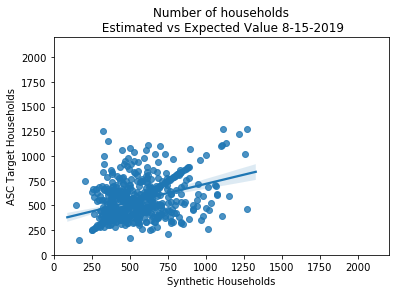

In [16]:
ax = sns.regplot(x="num_of_hh_synth", y="num_of_hh_target", data=hh_val)
plt.xlim(0, 2200)
plt.ylim(0, 2200)
plt.xlabel('Synthetic Households')
plt.ylabel('ASC Target Households')
ax.set_title('Number of households\n Estimated vs Expected Value 8-15-2019')
plt.show()

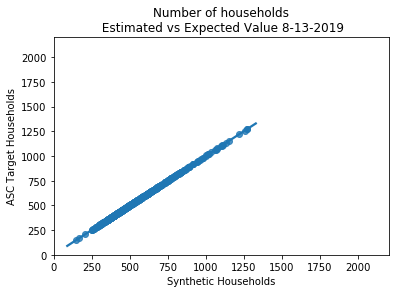

In [29]:
ax = sns.regplot(x="num_of_hh_synth", y="num_of_hh_target", data=hh_val)
plt.xlim(0, 2200)
plt.ylim(0, 2200)
plt.xlabel('Synthetic Households')
plt.ylabel('ASC Target Households')
ax.set_title('Number of households\n Estimated vs Expected Value 8-13-2019')
plt.show()

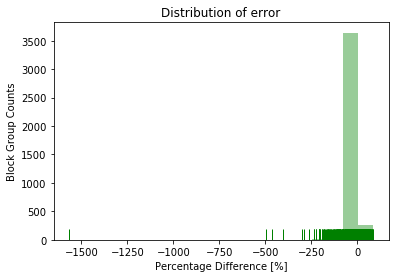

In [17]:
ax=sns.distplot(hh_val['pct_hh_diff'], kde=False, rug=True,bins=20,color= "g")
ax.set_ylabel('Block Group Counts')
plt.title('Distribution of error')
ax.set_xlabel('Percentage Difference [%]')
plt.show()

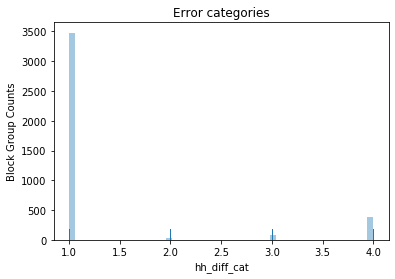

In [18]:
# categorize the discripancy column to visualize it
hh_val['hh_diff_cat']=hh_val['pct_hh_diff'].map(lambda x: 4 if abs(x)>20 else (3 if abs(x)>10 else (2 if abs(x)>5 else 1)))
ax=sns.distplot(hh_val['hh_diff_cat'],kde=False, rug=True)
ax.set_ylabel('Block Group Counts')
plt.title('Error categories')
plt.show()

### PERSONS

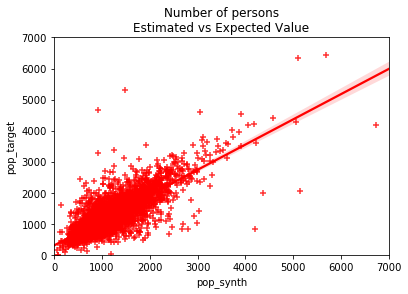

In [19]:
ax = sns.regplot(x="pop_synth", y="pop_target", data=pop_val, color='r',marker='+')
plt.xlim(0, 7000)
plt.ylim(0, 7000)
ax.set_title('Number of persons\nEstimated vs Expected Value')
plt.show()

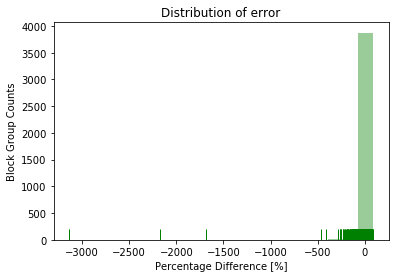

In [20]:
ax=sns.distplot(pop_val['pct_pop_diff'], kde=False, rug=True,bins=20,color= "g")
plt.title('Distribution of error')
ax.set_ylabel('Block Group Counts')
ax.set_xlabel('Percentage Difference [%]')
plt.show()

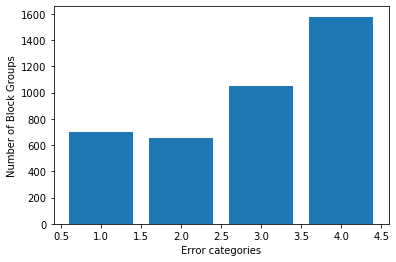

In [21]:
# categorize the discripancy column to visualize it
pop_val['pop_diff_cat']=pop_val['pct_pop_diff'].map(lambda x: 4 if abs(x)>20 else (3 if abs(x)>10 else (2 if abs(x)>5 else 1)))
a=pop_val['pop_diff_cat'].value_counts().to_frame()
plt.bar(a.index, a['pop_diff_cat'])
plt.xlabel('Error categories')
plt.ylabel('Number of Block Groups')
plt.show()

# Mapping the error by block group
With the blocks shapefile located in the data/directory, let's map the difference values

In [22]:
blocks = gpd.read_file('/home/data/chi/tl_2017_17_tabblock10.shp')
blocks.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,17,021,958700,4176,170219587004176,Block 4176,G5040,R,None,None,S,0,219026,+39.3725281,-089.0927334,"POLYGON ((-89.09852699999999 39.371416, -89.09..."
1,17,201,004003,1044,172010040031044,Block 1044,G5040,R,None,None,S,0,45258,+42.4688210,-089.0777438,"POLYGON ((-89.078346 42.467526, -89.0782859999..."
2,17,201,000200,3002,172010002003002,Block 3002,G5040,U,75718,U,S,216076,17947,+42.3228892,-089.0350716,"POLYGON ((-89.03724299999999 42.318589, -89.03..."
3,17,179,020100,3039,171790201003039,Block 3039,G5040,U,68509,U,S,0,28113,+40.6847558,-089.5910001,POLYGON ((-89.59206999999999 40.68506199999999...
4,17,001,010500,2099,170010105002099,Block 2099,G5040,R,None,None,S,0,103125,+39.9347482,-091.4208457,"POLYGON ((-91.42410799999999 39.93575, -91.418..."


In [24]:
blocks['geoid'] = blocks['GEOID10'].map(lambda x: str(x)[:12])
b_groups = blocks.dissolve(by = 'geoid')

In [25]:
#Merge the population values (synthetic and target) to the geopanda with the geoid
pop_val= pop_val.reset_index()
blocks_pp = pd.merge(b_groups,pop_val, how='outer',on='geoid')
blocks_pp = blocks_pp[blocks_pp.pop_synth.isna() == False]
blocks_pp['abs_pct_pop_diff'] = np.abs(blocks_pp.pct_pop_diff)

#Merge the household values (synthetic and target) to the geopanda with the geoid
hh_val= hh_val.reset_index()
blocks_p_hh = pd.merge(blocks_pp,hh_val, how='outer', on='geoid')
blocks_p_hh = blocks_p_hh[blocks_p_hh.num_of_hh_synth.isna() == False]
blocks_p_hh['abs_pct_hh_diff'] = np.abs(blocks_p_hh.pct_hh_diff)

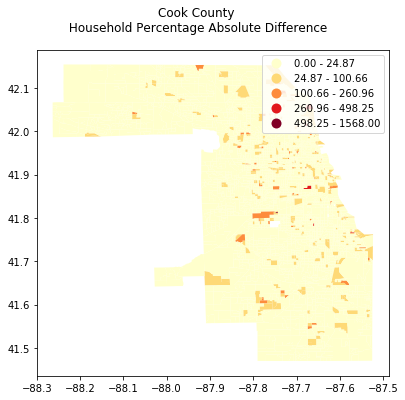

In [26]:
#Plot difference column for Households
f, ax = plt.subplots(1, figsize=(18, 6))
ax=blocks_p_hh.plot(column='abs_pct_hh_diff', cmap='YlOrRd',legend=True, axes=ax, scheme= 'fisher_jenks')
f.suptitle('{} County\n Household Percentage Absolute Difference'.format(county))
plt.show()

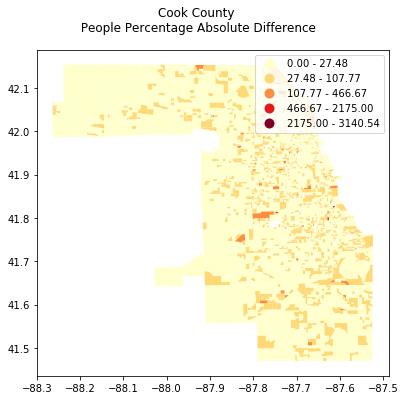

In [27]:
#Plot the difference column for PEOPLE
f, ax = plt.subplots(1, figsize=(18, 6))
ax=blocks_p_hh.plot(column='abs_pct_pop_diff', cmap='YlOrRd',legend=True, axes=ax, scheme= 'fisher_jenks')
f.suptitle('{} County\n People Percentage Absolute Difference'.format(county))
plt.show()

Let's look at the blocks that show a high absolute percentage of difference between the synthetic results and the agreggate data form the ACS

In [28]:
#BLOCKS THAT HAVE A HIGH ABSOLUTE PERCENTAGE DIFFERENCE IN SYNTHETIC RESULTS AND TARGETS FOR HOUSEHOLDS AND PEOPLE
blocks_p_hh[(blocks_p_hh.abs_pct_pop_diff > 25)|(blocks_p_hh.abs_pct_hh_diff > 5)][['geoid','num_of_hh_synth','num_of_hh_target','abs_pct_hh_diff','pop_synth','pop_target','abs_pct_pop_diff']].sort_values(['abs_pct_pop_diff','abs_pct_pop_diff'])

,geoid,num_of_hh_synth,num_of_hh_target,abs_pct_hh_diff,pop_synth,pop_target,abs_pct_pop_diff
389,170310815001,814,932,12.660944,1357.0,1357.0,0.000000
1527,170316204002,255,234,8.974359,942.0,941.0,0.106270
1131,170314102001,501,623,19.582665,891.0,893.0,0.223964
3569,170318280002,402,321,25.233645,942.0,946.0,0.422833
3218,170318226023,1009,1388,27.305476,2573.0,2559.0,0.547089
93,170310303002,843,690,22.173913,1613.0,1625.0,0.738462
1509,170316118002,330,160,106.250000,585.0,590.0,0.847458
2628,170318102004,379,589,35.653650,1001.0,1010.0,0.891089
2211,170318043064,326,349,6.590258,1142.0,1131.0,0.972591
1072,170313204001,389,587,33.730835,709.0,700.0,1.285714


# Attributes Validation
In this section, the synthetic attributes will be compared with the target ones. This validation is done on controlled and uncontrolled variables. <br> 
Household tables are: hh_target2, hh_synth.<br> Person level tables are: p_target, p_synth

Create categories to compare with target (ACS) table on Household Tables

In [33]:
hh_synth2=hh_synth[['household_id','geoid','persons','children','workers','income','cars',
                    'race_of_head','age_of_head', 'tenure', 'recent_mover', 'hispanic_head']]

def age_of_head(x):
    if x <=35:
        return 'lt35'
    elif (x >35) & (x <=65):
        return 'gt35-lt65'
    else:
        return 'gt65'
def income(x):
    if x <=30000:
        return 'lt30'
    elif (x >30000) & (x <=60000):
        return 'gt30-lt60'
    elif(x >60000) & (x <=100000):
        return 'gt60-lt100'
    elif (x >100000) & (x <=150000):
        return 'gt100-lt150'
    else:
        return 'gt150'
def size(x):
    if x == 1:
        return 'one'
    elif x == 2:
        return 'two'
    elif x == 3:
        return 'three'
    else:
        return 'four or more' 
def workers(x):
    if x == 0.0:
        return 'none'
    elif x == 1.0:
        return 'one'
    else:
        return 'two or more'
def cars(x):
    if x == 0:
        return 'none'
    elif x == 1:
        return 'one'
    else:
        return 'two or more'
def tenure(x):
    if x == 1:
        return 'owner'
    elif x == 2:
        return 'renter'
    else:
        return np.nan
def recent_mover(x):
    if x == 1:
        return 'yes'
    elif x == 0:
        return 'no'
    else:
        return np.nan
def children(x):
    if (isinstance(x, int)) | (isinstance(x, float)): 
        if x >= 1:
            return 'yes'
        elif x == 0:
            return 'no'
    else:
        return x
def hispanic(x):
    if x == 1:
        return 'yes'
    elif x == 0:
        return 'no'
    else:
        return np.nan

hh_synth2['hh_race_of_head']= hh_synth2.race_of_head.map({6:'asian', 1:'white', 9:'other', 
                                                          7:'other', 2:'black', 8:'other', 5:'other',
                                                          3:'other',4:'other'})
hh_synth2['hh_size'] = hh_synth2.persons.map(size)
hh_synth2['hh_age_of_head'] = hh_synth2.age_of_head.map(age_of_head)
hh_synth2['hh_children'] = hh_synth2.children.map(children)
hh_synth2['hh_workers'] = hh_synth2.workers.map(workers)
hh_synth2['hh_income'] = hh_synth2.income.map(income)
hh_synth2['hh_cars'] = hh_synth2.cars.map(cars)
hh_synth2['recent_mover'] = hh_synth2.recent_mover.map(recent_mover)
hh_synth2['tenure'] = hh_synth2.tenure.map(tenure)
# hh_synth2['hispanic_head'] = hh_synth2.hispanic_status_of_head.map(hispanic)

# Make dummy columns
cols_to_transform=['hh_size','hh_workers','hh_cars','hh_age_of_head',
                   'hh_race_of_head','hh_income','hh_children','tenure','recent_mover','hispanic_head']
hh_synth2=pd.get_dummies(hh_synth2,columns = cols_to_transform)
pd.set_option('display.max_columns',500)
hh_synth2.head()

,household_id,geoid,persons,children,workers,income,cars,race_of_head,age_of_head,hh_size_four or more,hh_size_one,hh_size_three,hh_size_two,hh_workers_none,hh_workers_one,hh_workers_two or more,hh_cars_none,hh_cars_one,hh_cars_two or more,hh_age_of_head_gt35-lt65,hh_age_of_head_gt65,hh_age_of_head_lt35,hh_race_of_head_asian,hh_race_of_head_black,hh_race_of_head_other,hh_race_of_head_white,hh_income_gt100-lt150,hh_income_gt150,hh_income_gt30-lt60,hh_income_gt60-lt100,hh_income_lt30,hh_children_no,hh_children_yes,tenure_owner,tenure_renter,recent_mover_no,recent_mover_yes,hispanic_head_no,hispanic_head_yes
0,0,170312421001,2,0.0,2.0,112000.0,0.0,1,36,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0
1,1,170312421001,1,0.0,1.0,31000.0,0.0,1,55,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0
2,2,170312421001,1,0.0,1.0,35000.0,0.0,1,35,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0
3,3,170312421001,1,0.0,1.0,60000.0,0.0,1,58,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0
4,4,170312421001,1,0.0,1.0,11200.0,0.0,1,50,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,1,0


In [34]:
# Aggregate Distribution of syntehtic results by geoid (block group)
synth_hh_totals=hh_synth2.groupby('geoid').agg(sum)
synth_hh_totals1=synth_hh_totals.sum().to_frame().T
synth_hh_totals.head()

,household_id,persons,children,workers,income,cars,race_of_head,age_of_head,hh_size_four or more,hh_size_one,hh_size_three,hh_size_two,hh_workers_none,hh_workers_one,hh_workers_two or more,hh_cars_none,hh_cars_one,hh_cars_two or more,hh_age_of_head_gt35-lt65,hh_age_of_head_gt65,hh_age_of_head_lt35,hh_race_of_head_asian,hh_race_of_head_black,hh_race_of_head_other,hh_race_of_head_white,hh_income_gt100-lt150,hh_income_gt150,hh_income_gt30-lt60,hh_income_gt60-lt100,hh_income_lt30,hh_children_no,hh_children_yes,tenure_owner,tenure_renter,recent_mover_no,recent_mover_yes,hispanic_head_no,hispanic_head_yes
geoid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
170310101001,150400222,610,113.0,329.0,17214404.0,203.0,641,15326,51.0,161.0,18.0,81.0,82.0,139.0,90.0,162.0,103.0,46.0,270.0,7.0,34.0,0.0,165.0,23.0,123.0,94.0,7.0,0.0,24.0,186.0,252.0,59.0,92.0,219.0,311.0,0.0,283.0,28.0
170310101002,402832352,1563,364.0,847.0,29775209.0,539.0,1795,40259,85.0,418.0,74.0,255.0,235.0,362.0,235.0,432.0,287.0,113.0,625.0,57.0,150.0,13.0,441.0,64.0,314.0,47.0,21.0,96.0,87.0,581.0,599.0,233.0,35.0,797.0,776.0,56.0,764.0,68.0
170310101003,514226670,1863,270.0,1142.0,60509975.0,681.0,1712,44575,84.0,553.0,48.0,375.0,278.0,461.0,321.0,540.0,370.0,150.0,539.0,38.0,483.0,34.0,265.0,30.0,731.0,155.0,8.0,175.0,338.0,384.0,906.0,154.0,184.0,876.0,1028.0,32.0,960.0,100.0
170310102011,300322353,1281,212.0,662.0,32736336.0,588.0,1185,30517,52.0,187.0,89.0,290.0,142.0,300.0,176.0,158.0,345.0,115.0,404.0,80.0,134.0,24.0,260.0,26.0,308.0,88.0,24.0,72.0,95.0,339.0,481.0,137.0,231.0,387.0,595.0,23.0,567.0,51.0
170310102012,208700778,928,189.0,466.0,29676156.0,413.0,597,20244,66.0,115.0,0.0,248.0,95.0,208.0,126.0,103.0,245.0,81.0,253.0,39.0,137.0,0.0,168.0,0.0,261.0,11.0,45.0,133.0,124.0,116.0,333.0,96.0,190.0,239.0,415.0,14.0,394.0,35.0


In [35]:
#Format TARGET table
#have one level index
hh_target2=hh_target2.copy().reset_index()
hh_target2['geoid']=hh_target2['county']+hh_target2['tract']+hh_target2['block group']
hh_target2.columns = ['_'.join(col).strip() for col in hh_target2.columns.values]
#Aggregate values
hh_target3=hh_target2.sum().to_frame().T

# format target tables for Tenure
hh_target3['tenure_owner']=hh_target3['tenure_mover_own not recent']+hh_target3['tenure_mover_own recent']
hh_target3['tenure_renter']= hh_target3['tenure_mover_rent not recent']+hh_target3['tenure_mover_rent recent']

hh_target3['recent_mover_yes']=hh_target3['tenure_mover_own recent']+hh_target3['tenure_mover_rent recent']
hh_target3['recent_mover_no']= hh_target3['tenure_mover_rent not recent']+hh_target3['tenure_mover_own not recent']

Create categories to compare with target (ACS) table for PERSONS

In [45]:
p_synth.rename(columns={'age':'person_age','sex':'person_sex','race_id':'race'},inplace=True)
p_synth2=p_synth[['person_id','geoid','person_age','person_sex','race','hispanic.1']]

# #Map the variable names to match the ACS ones
def person_age(x):
    if x <=19:
        return '19 and under'
    elif (x >=20) & (x <35):
        return '20 to 35'
    elif (x >=35) & (x <60):
        return '35 to 60'
    else:
        return 'above 60'
def person_sex(x):
    if x ==1:
        return 'male'
    else:
        return 'female'
def hispanic(x):
    if x == 1:
        return 'yes'
    elif x == 0:
        return 'no'
    else:
        return np.nan


p_synth2['race']= p_synth2.race.map({6:'asian', 1:'white', 9:'other', 
                                                          7:'other', 2:'black', 8:'other', 5:'other',
                                                          3:'other',4:'other'})
p_synth2['person_age'] = p_synth2.person_age.map(person_age)
p_synth2['person_sex'] = p_synth2.person_sex.map(person_sex)
# p_synth2['hispanic'] = p_synth2['hispanic.1'].map(hispanic)
p_synth2['hispanic'] = p_synth2['hispanic.1']

# Make dummy columns
cols_to_transform=['person_age','person_sex','race','hispanic']
p_synth2=pd.get_dummies(p_synth2,columns = cols_to_transform)

# Aggregate by geoid (block group)
synth_p_totals=p_synth2.groupby('geoid').agg(sum)
synth_p_totals1=synth_p_totals.sum().to_frame().T

In [46]:
p_synth2.columns

Index(['person_id', 'geoid', 'hispanic.1', 'person_age_19 and under',
       'person_age_20 to 35', 'person_age_35 to 60', 'person_age_above 60',
       'person_sex_female', 'person_sex_male', 'race_asian', 'race_black',
       'race_other', 'race_white', 'hispanic_no', 'hispanic_yes'],
      dtype='object')

In [47]:
#Format the TARGET table to have one level index
p_target2=p_target2.copy().reset_index()
p_target2['geoid']=p_target2['state'] + p_target2['county']+p_target2['tract']+p_target2['block group']
p_target2.columns = ['_'.join(col).strip() for col in p_target2.columns.values]
p_target3=p_target2.sum().to_frame().T

KeyError: 'state'

#### Let's graph synthetic results with target/marginal values

In [38]:
hh_target3

,state_,county_,tract_,block group_,hh_age_of_head_gt35-lt65,hh_age_of_head_gt65,hh_age_of_head_lt35,hh_cars_none,hh_cars_one,hh_cars_two or more,hh_children_no,hh_children_yes,hh_income_gt100-lt150,hh_income_gt150,hh_income_gt30-lt60,hh_income_gt60-lt100,hh_income_lt30,hh_race_of_head_asian,hh_race_of_head_black,hh_race_of_head_other,hh_race_of_head_white,hh_size_four or more,hh_size_one,hh_size_three,hh_size_two,hh_workers_none,hh_workers_one,hh_workers_two or more,hispanic_head_no,hispanic_head_yes,seniors_no,seniors_yes,sf_detached_no,sf_detached_yes,tenure_mover_own not recent,tenure_mover_own recent,tenure_mover_rent not recent,tenure_mover_rent recent,geoid_,tenure_owner,tenure_renter,recent_mover_yes,recent_mover_no
0,inf,inf,inf,inf,1102802.0,426835.0,421969.0,346295.0,791855.0,804320.0,1358627.0,592979.0,269196.0,252754.0,468389.0,416964.0,544303.0,123467.0,466784.0,169505.0,1191850.0,451534.0,631626.0,295187.0,573259.0,490090.0,802072.0,651843.0,1608453.0,343153.0,1458613.0,492993.0,1130380.0,821226.0,1082859.0,22309.0,770364.0,76074.0,inf,1105168.0,846438.0,98383.0,1853223.0


VALIDATION OF HOUSEHOLD ATTRIBUTES


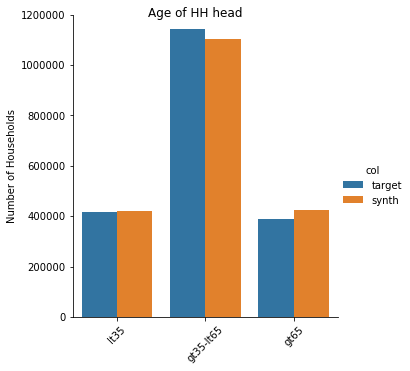

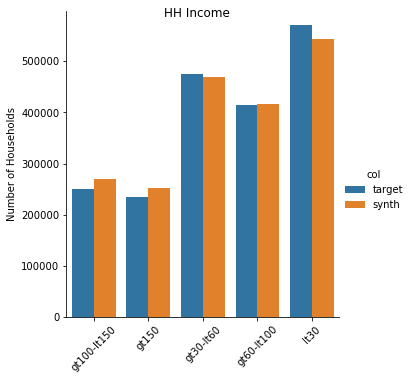

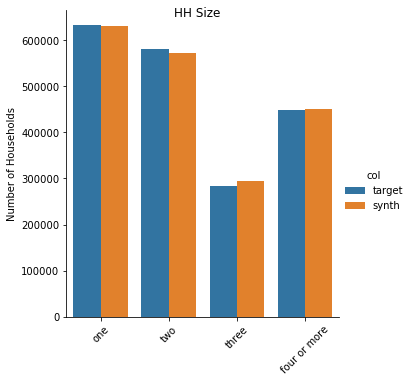

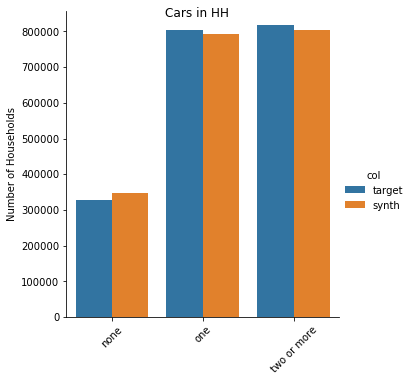

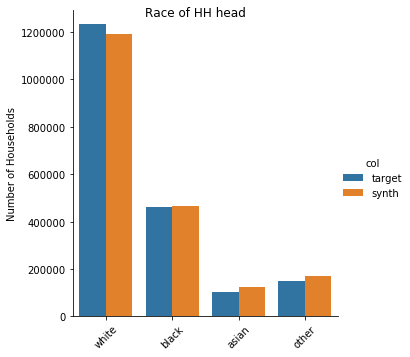

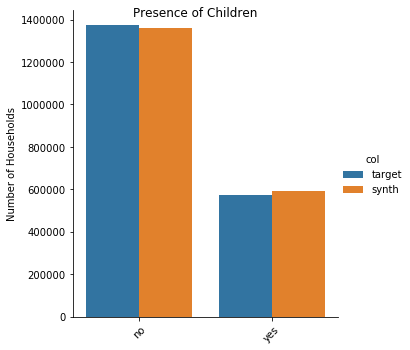

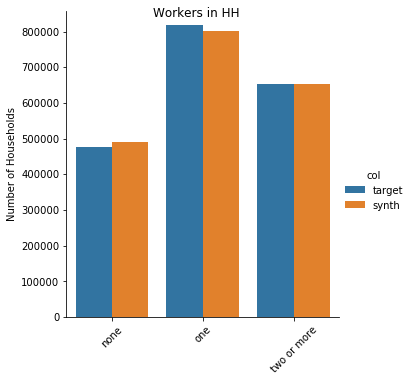

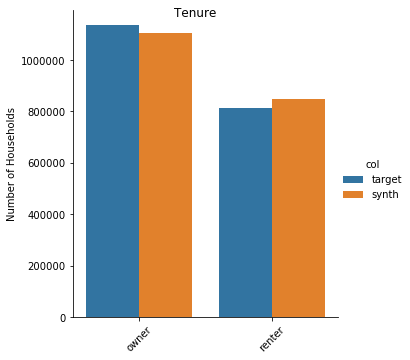

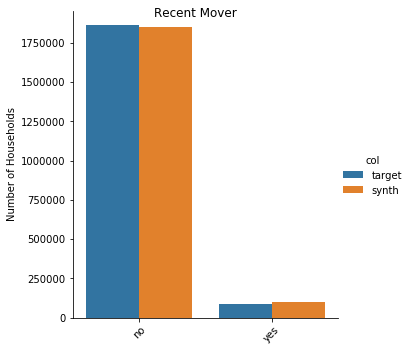

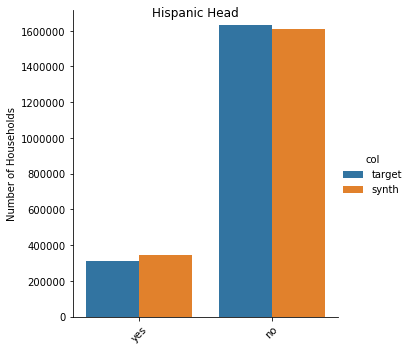

In [39]:
graph_sets = {'Age of HH head': ['hh_age_of_head_lt35','hh_age_of_head_gt35-lt65','hh_age_of_head_gt65'],
    'HH Income': ['hh_income_gt100-lt150', 'hh_income_gt150',
        'hh_income_gt30-lt60','hh_income_gt60-lt100','hh_income_lt30'],
    'HH Size': ['hh_size_one','hh_size_two','hh_size_three','hh_size_four or more'],
    'Cars in HH': ['hh_cars_none','hh_cars_one','hh_cars_two or more'],
    'Race of HH head': ['hh_race_of_head_white','hh_race_of_head_black',
        'hh_race_of_head_asian','hh_race_of_head_other'],
    'Presence of Children': ['hh_children_no','hh_children_yes'],
    'Workers in HH': ['hh_workers_none','hh_workers_one','hh_workers_two or more'],
        'Tenure': ['tenure_owner','tenure_renter'],
    'Recent Mover': ['recent_mover_no','recent_mover_yes'],
    'Hispanic Head': ['hispanic_head_yes','hispanic_head_no']}
print('VALIDATION OF HOUSEHOLD ATTRIBUTES')
for key, value in graph_sets.items():
    x = value
    target_hh_slice=hh_target3[x]
    synth_hh_slice= synth_hh_totals1[x]
    synth_hh_slice.index=target_hh_slice.index
    
    df = pd.concat([synth_hh_slice.T, target_hh_slice.T], axis=0, ignore_index=False)
    df['col'] = (len(synth_hh_slice.T)*(0,) + len(target_hh_slice.T)*(1,))
    df.reset_index(inplace=True)
    df.rename(columns = {0:'Number of Households'}, inplace = True)
    df['col']= df['col'].map(lambda x: 'target' if x==0 else 'synth')
    labels = [lab[lab.rindex('_')+1:] for lab in value]
    ax = sns.factorplot(data=df,x='index', y='Number of Households', hue='col', kind='bar')
    ax.set_xticklabels(labels)
    ax.set_xlabels('')
    plt.suptitle(key)
    plt.xticks(rotation=45)
    plt.show()

VALIDATION OF POPULATION ATTRIBUTES


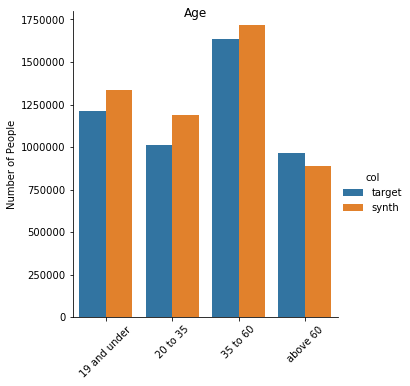

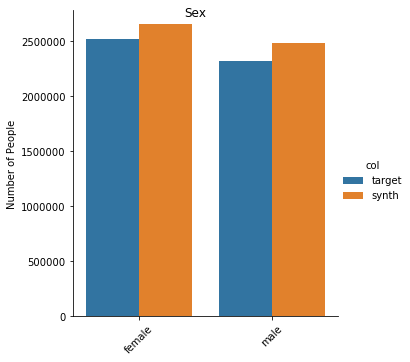

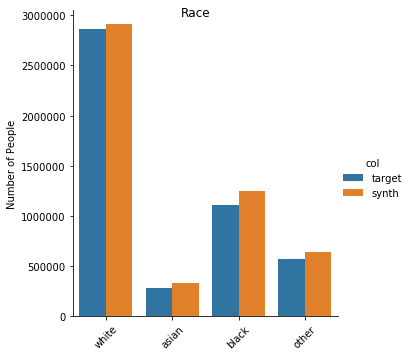

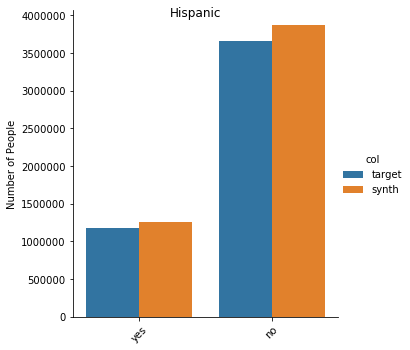

In [48]:
graph_sets = {    'Age': ['person_age_19 and under','person_age_20 to 35','person_age_35 to 60','person_age_above 60'],
    'Sex': ['person_sex_female', 'person_sex_male'],
    'Race': ['race_white','race_asian', u'race_black','race_other'],
    'Hispanic': ['hispanic_yes','hispanic_no']}
print('VALIDATION OF POPULATION ATTRIBUTES')
for key, value in graph_sets.items():
    x = value
    target_hh_slice=p_target3[x]
    synth_hh_sclice= synth_p_totals1[x]
    synth_hh_sclice.index=target_hh_slice.index
    
    df = pd.concat([synth_hh_sclice.T, target_hh_slice.T], axis=0, ignore_index=False)
    df['col'] = (len(synth_hh_sclice.T)*(0,) + len(target_hh_slice.T)*(1,))
    df.reset_index(inplace=True)
    df.rename(columns = {0:'Number of People'}, inplace = True)
    df['col']= df['col'].map(lambda x: 'target' if x==0 else 'synth')
    labels = [lab[lab.rindex('_')+1:] for lab in value]
    ax = sns.factorplot(data=df,x='index', y='Number of People', hue='col', kind='bar')
    ax.set_xticklabels(labels)
    ax.set_xlabels('')
    plt.suptitle(key)
    plt.xticks(rotation=45)
    plt.show()